In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw.rdMolDraw2D import MolDraw2DCairo
from rdkit.Chem.Draw.rdMolDraw2D import MolDrawOptions
from rdkit.Geometry.rdGeometry import Point2D
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from typing import *
from PIL import Image
import io

In [2]:
%load_ext autoreload
%autoreload 2

In [7]:
from rdkit_heatmaps import heatmaps
from rdkit_heatmaps.utils import get_mol_lims
from rdkit_heatmaps.utils import pad
from rdkit_heatmaps.utils import transform2png
from rdkit_heatmaps.functions import GaussFunction2D
from rdkit_heatmaps import mapvalues2mol

In [8]:
test_mol = Chem.MolFromSmiles("c1ccccc1-C-c2ccccc2")
test_mol = Draw.PrepareMolForDrawing(test_mol)

In [17]:
random_gen = np.random.default_rng(12345)
atom_weights = random_gen.normal(loc=0.25, scale=0.5, size=len(test_mol.GetAtoms()))
bond_weights = random_gen.normal(loc=-0.25, scale=0.5, size=len(test_mol.GetBonds()))

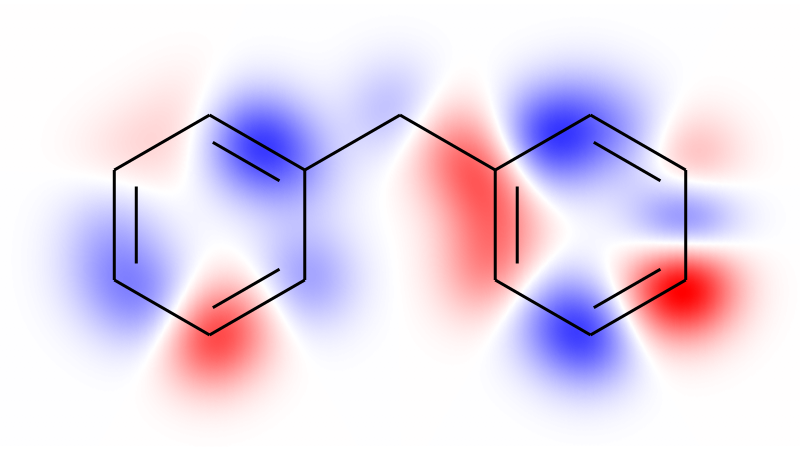

In [18]:
canvas = mapvalues2mol(test_mol, atom_weights, bond_weights)
img = transform2png(canvas.GetDrawingText())
img

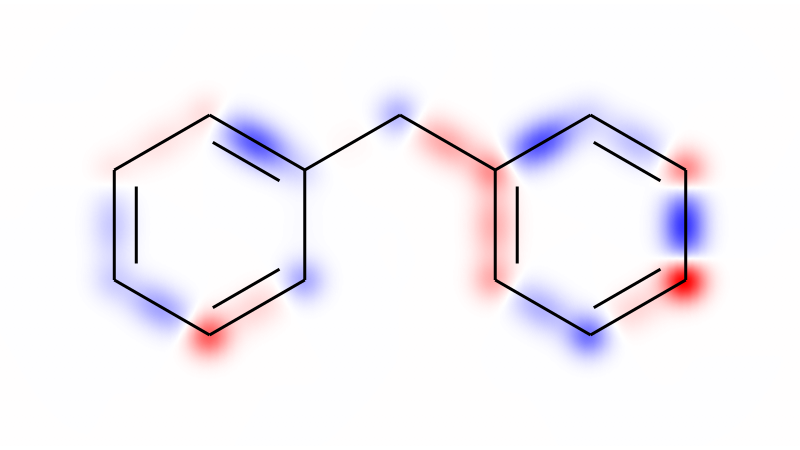

In [19]:
canvas = mapvalues2mol(test_mol, atom_weights, bond_weights, atom_width=0.2, bond_length=0.35, bond_width=0.2)
img = transform2png(canvas.GetDrawingText())
img

In [21]:
image = np.array(Image.open('039.jpg'))
image = image / 255
image = np.flip(image, axis=0)
ones = np.ones([*image.shape[:2], 1])
image = np.append(image, ones, axis=2)
image = np.swapaxes(image,1,0)
s = 5
c_grid = heatmaps.ColorGrid([s,-s], [s/8*4.5,-s/8*4.5], image.shape[0], image.shape[1])
c_grid.color_grid = image

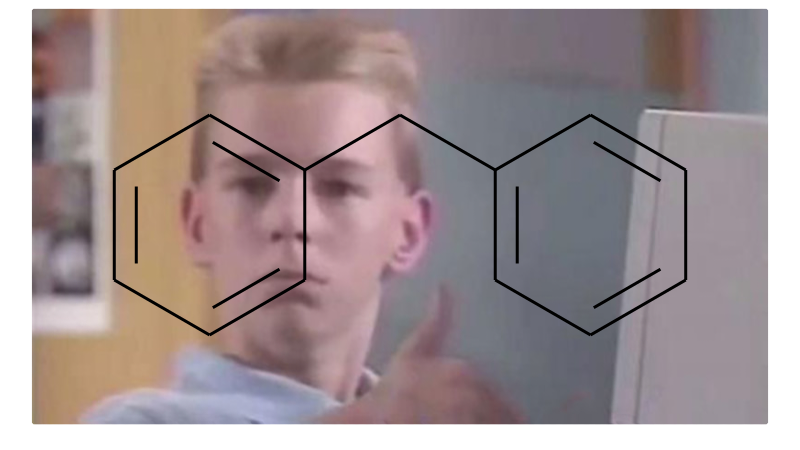

In [10]:
d = MolDraw2DCairo(800, 450)
do = d.drawOptions()
do.padding = 0.2
do.bondLineWidth = 3
d.SetDrawOptions(do)
d.DrawMolecule(test_mol)
heatmaps.color_canvas(d, c_grid)
d.DrawMolecule(test_mol)
transform2png(d.GetDrawingText())